In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
from shapely import wkt
import matplotlib.pyplot as plt
from pyproj import Proj, transform
import seaborn as sns

In [2]:
tab = pd.read_html('https://wiki.openstreetmap.org/wiki/Key:building', match='Value')
tab

[             Key         Value  \
    Accommodation Accommodation   
 0       building    apartments   
 1       building      barracks   
 2       building      bungalow   
 3       building         cabin   
 4       building      detached   
 ..           ...           ...   
 91      building          roof   
 92      building         ruins   
 93      building          tent   
 94      building           yes   
 95      building  user defined   
 
                                               Comment         Photo  \
                                         Accommodation Accommodation   
 0   A building arranged into individual dwellings,...           NaN   
 1   Buildings built to house military personnel or...           NaN   
 2        A single-storey detached small house, Dacha.           NaN   
 3   A cabin is a small, roughly built house usuall...           NaN   
 4   A detached house, a free-standing residential ...           NaN   
 ..                                    

In [3]:
building_types = tab[0]
building_types.index = np.arange(len(building_types))

In [4]:
building_types.columns = building_types.columns.droplevel(1)
building_types

,Key,Value,Comment,Photo,Unnamed: 4_level_0,Unnamed: 5_level_0,Unnamed: 6_level_0
0,building,apartments,"A building arranged into individual dwellings,...",NaN,NaN,NaN,NaN
1,building,barracks,Buildings built to house military personnel or...,NaN,NaN,NaN,NaN
2,building,bungalow,"A single-storey detached small house, Dacha.",NaN,NaN,NaN,NaN
3,building,cabin,"A cabin is a small, roughly built house usuall...",NaN,NaN,NaN,NaN
4,building,detached,"A detached house, a free-standing residential ...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
91,building,roof,A structure that consists of a roof with open ...,NaN,NaN,NaN,NaN
92,building,ruins,Frequently used for a house or other building ...,NaN,NaN,NaN,NaN
93,building,tent,For a permanently placed tent. Do not map tent...,NaN,NaN,NaN,NaN
94,building,yes,Use this value where it is not possible to det...,NaN,NaN,NaN,NaN


In [5]:
categories_df = building_types[building_types['Key'] != 'building']
categories = ['Accomodation']
categories.extend(categories_df['Key'])
categories_ind = categories_df.index
categories_ind, categories
desired_slices = [np.arange(18,25), np.arange(26, 37), np.arange(38, 53), np.arange(69, 72)]
desired_inds = np.concatenate(desired_slices)
desired_types = list(building_types.loc[desired_inds]['Value'])
desired_types

['commercial',
 'industrial',
 'kiosk',
 'office',
 'retail',
 'supermarket',
 'warehouse',
 'cathedral',
 'chapel',
 'church',
 'kingdom_hall',
 'monastery',
 'mosque',
 'presbytery',
 'religious',
 'shrine',
 'synagogue',
 'temple',
 'bakehouse',
 'bridge',
 'civic',
 'college',
 'fire_station',
 'government',
 'gatehouse',
 'hospital',
 'kindergarten',
 'public',
 'school',
 'toilets',
 'train_station',
 'transportation',
 'university',
 'hangar',
 'hut',
 'shed']

In [6]:
center_point = (37.874473146528274, -122.25821473949732)
#tags = {'amenity':'!parking', 'landuse':['retail','commercial'], 'highway':'bus_stop'}
#tags = {'amenity':['bicycle_parking','bicycle_repair_station'],
#'public_transport': True,
#'highway': 'bus_stop'}
#tags = {'amenity':'!parking', 'landuse':['retail','commercial']}
#tags = {'building': True}
#tags = {'amenity': True}
#not_accomodations = ['!apartments', '!barracks', '!bungalow', \
#    '!cabin', '!detached', '!dormitory', \
#    '!farm', '!ger', '!hotel', \
#    '!house', '!houseboat', \
#    '!residential', '!semidetached_house', '!static_caravan', \
#    '!stilt_house', '!terrace', '!tree_house']
#accomodations = ['apartments', 'barracks', 'bungalow', \
#    'cabin', 'detached', 'dormitory', \
#    'farm', 'ger', 'hotel', \
#    'house', 'houseboat', \
#    'residential', 'semidetached_house', 'static_caravan', \
#    'stilt_house', 'terrace', 'tree_house']
#tags = {'building': True, 'building': not_accomodations}
#tags = {'building': '~apartments'}
tags = {'building': desired_types, 'amenity': True}
#tags = {'amenity': 'restaurant'}
G = ox.geometries_from_point(center_point, tags, dist=10000)
#G.geometry.centroid.plot(alpha=0.2, markersize=10)

<AxesSubplot: >

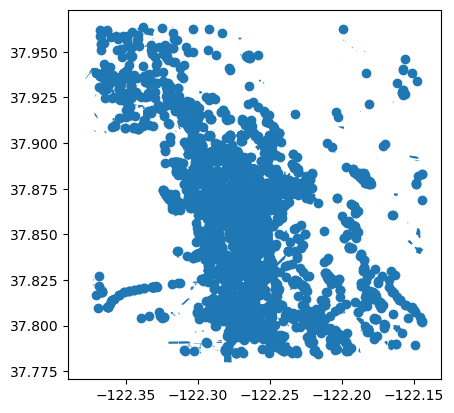

In [108]:
G.plot()

In [7]:
#G[G['amenity'] != 'parking'].explore()
G.explore()

In [2]:
ca_data_pd = pd.read_csv('ca_data.csv')
ca_data_pd['geometry'] = ca_data_pd['geometry'].apply(wkt.loads)
ca_data = gpd.GeoDataFrame(ca_data_pd)
#ca_data['pov_pct'] = ca_data['total_pov_below'] / ca_data['total_pop']
#ca_data['area'] = ca_data.geometry.area
#ca_data['pop_density'] = ca_data['total_pop'] / ca_data['area']
#ca_data.to_csv('ca_data.csv')
poor_urban_tracts = ca_data[(ca_data['pov_pct'] > 0.18) & \
    #(ca_data['pov_pct'] < 0.5) & \
    (ca_data['pop_density'] > 0.000153)]

In [3]:
poor_urban_tracts.geometry.area.describe()

count    1.824000e+03
mean     3.316752e+06
std      4.912937e+06
min      9.073566e+04
25%      8.633952e+05
50%      1.760596e+06
75%      3.468537e+06
max      4.783457e+07
dtype: float64

In [4]:
inProj = Proj(init='epsg:3857')
outProj = Proj(init='epsg:4326')

centroids = poor_urban_tracts.geometry.centroid
centroids_tuples = centroids.apply(lambda c: transform(inProj, outProj, \
    c.coords[0][0], c.coords[0][1], always_xy=True))
poor_urban_tracts['centroids'] = centroids_tuples.apply(lambda t: (t[1], t[0]))

/Users/giuseppeperona/opt/anaconda3/envs/ox/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/giuseppeperona/opt/anaconda3/envs/ox/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_1216/1918768990.py:5: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io

In [11]:
tags = {'amenity':True, 'landuse':['retail','commercial'], 'highway':'bus_stop'}

def get_n_pois(row):
    center_point = row['centroids']
    area = row['area']
    dist = np.sqrt(area) / 2
    G = ox.geometries_from_point(center_point, tags, dist=dist)
    return len(G)

poor_urban_tracts['tot_pois'] = poor_urban_tracts.apply(lambda r: get_n_pois(r), axis=1)
poor_urban_tracts.to_csv('poor_urban_tracts.csv')

/Users/giuseppeperona/opt/anaconda3/envs/ox/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


(array([ 11.,   0.,  18.,   0.,  22.,  32.,  15.,  67.,  81.,  74., 135.,
        141., 185., 149., 180., 151., 120.,  99., 102.,  74.,  57.,  35.,
         35.,  18.,   5.,  13.,   3.,   1.,   0.,   1.]),
 array([0.        , 0.10756192, 0.21512384, 0.32268576, 0.43024768,
        0.5378096 , 0.64537151, 0.75293343, 0.86049535, 0.96805727,
        1.07561919, 1.18318111, 1.29074303, 1.39830495, 1.50586687,
        1.61342879, 1.7209907 , 1.82855262, 1.93611454, 2.04367646,
        2.15123838, 2.2588003 , 2.36636222, 2.47392414, 2.58148606,
        2.68904798, 2.79660989, 2.90417181, 3.01173373, 3.11929565,
        3.22685757]),
 <BarContainer object of 30 artists>)

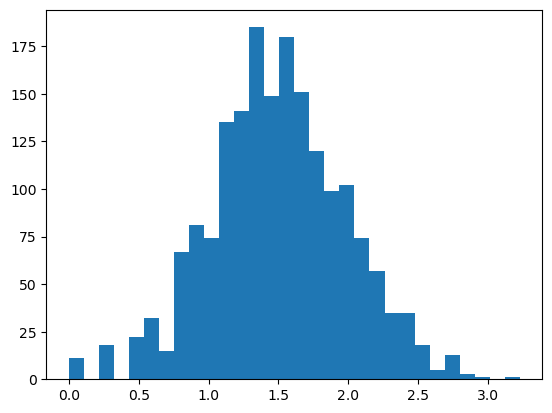

In [16]:
plt.hist(np.log10(poor_urban_tracts['tot_pois']+1), bins=30)

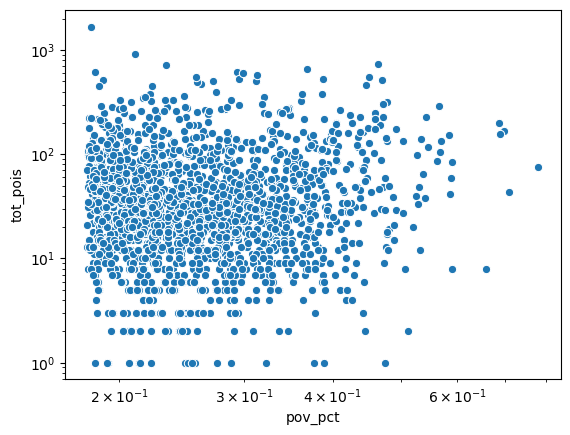

In [23]:
sns.scatterplot(data=poor_urban_tracts, x='pov_pct', y='tot_pois')
plt.yscale('log')
plt.xscale('log')

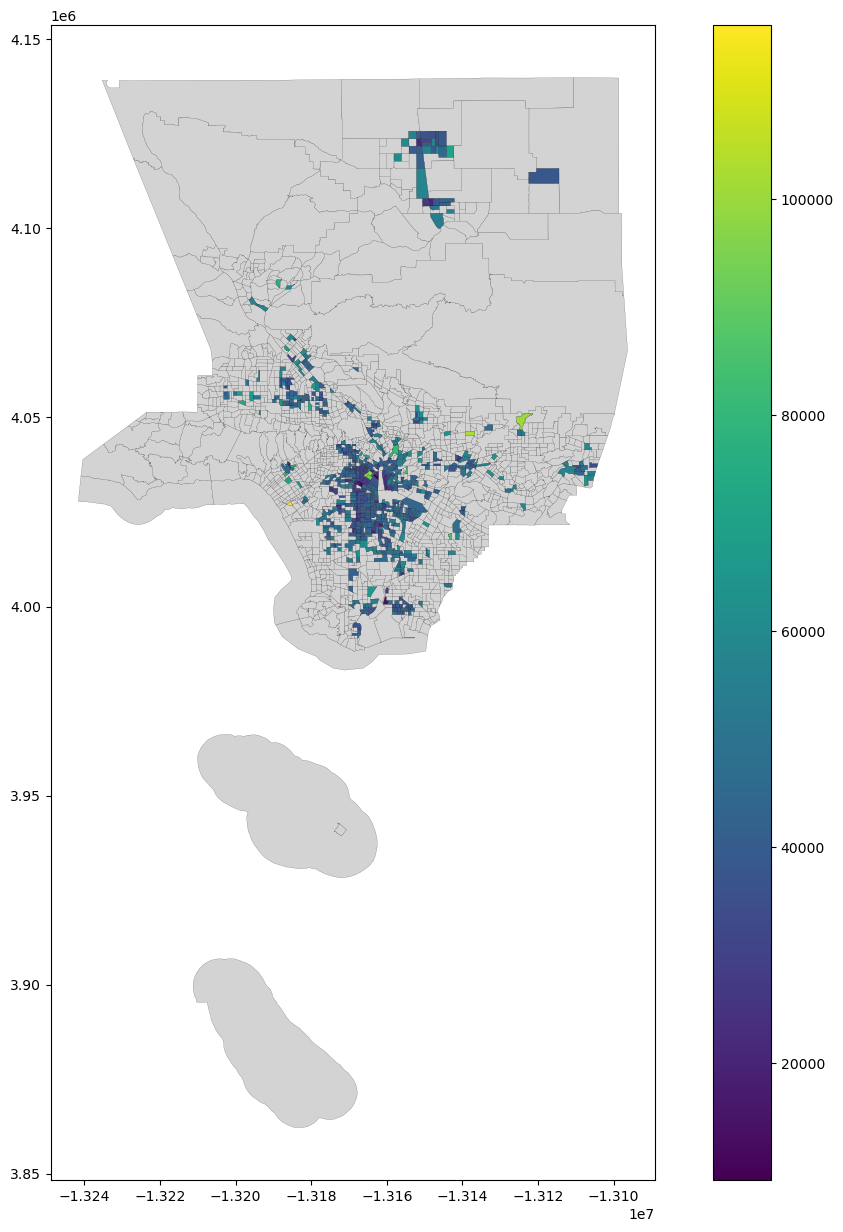

In [80]:
def plot_counties(counties_regex, var, figsize=(15,15)):
    ax = ca_data[ca_data['NAME'].str.contains(counties_regex)].plot(color='lightgray', figsize=figsize, edgecolor='k', linewidth=0.1)
    poor_urban_tracts[poor_urban_tracts['NAME'].str.contains(counties_regex)].plot(var, legend=True, ax=ax, edgecolor='k', linewidth=0.1)

plot_counties(r'Los Angeles', 'median_income')

In [40]:
ox.graph_from_place(poor_urban_tracts['NAME'].iloc[0])

ValueError: Nominatim geocoder returned 0 results for query "Census Tract 1.01, Del Norte County, California"

In [58]:
ca_data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'GEOID', 'geometry', 'total_pop',
       'male_25_29', 'male_30_34', 'male_35_39', 'male_40_44', 'female_25_29',
       'female_30_34', 'female_35_39', 'female_40_44', 'race_white',
       'race_black', 'race_am_ind', 'race_asian', 'race_hi_pi', 'race_other',
       'race_2_plus', 'tot_25_plus', 'bach_higher_25_plus',
       'workers_who_commute', 'agg_travel_time_min', 'veh_avail_tot',
       'veh_avail_none', 'veh_avail_1', 'veh_avail_2', 'veh_avail_3p',
       'total_pov', 'total_pov_below', 'total_pov_above', 'median_income',
       'household_size', 'med_housing_cost', 'housing_total',
       'owner_cost_gt_30_pct_br_1', 'owner_cost_gt_30_pct_br_2',
       'owner_cost_gt_30_pct_br_3', 'owner_cost_gt_30_pct_br_4',
       'owner_cost_gt_30_pct_br_5', 'renter_cost_gt_30_pct_br_1',
       'renter_cost_gt_30_pct_br_2', 'renter_cost_gt_30_pct_br_3',
       'renter_cost_gt_30_pct_br_4', 'renter_cost_gt_30_pct_br_5',
       'labor_force', 'employed', '

In [95]:
ca_data.geometry.crs

In [110]:
ox.pois

AttributeError: module 'osmnx' has no attribute 'pois'

In [ ]:
ca_data[ca_data['NAME'].str.contains(r'Alameda')]